## Pnet torch implementation

Our torch implementation of pnet does not produce the same results as the original tf implementation, even though I have captured every feature of the architecture I can find. The model is described in the "Methods" section of: https://www.nature.com/articles/s41586-021-03922-4. Things we have included below:

1. First layer is a "dense" layer, taking the 3 features for each gene and collapsing them into 1 latent variable. We then follow up with sparse NN layers.
2. Tanh activations between each pnet hidden layer
3. Each layer also has a linear layer with a sigmoid activation, producing a predictive output. The final prediction during training is a weighted sum of the losses of each of these intermediate predictive outputs, along with the final output of the network. The loss weights are the same as in the tf version.
4. They use a BCE loss
5. As far as I understand it, validation/test predictions do not use this weighted output, only the prediction of the final layer.
6. Adam optimizer

In [1]:
import time
import os
import numpy as np

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler, RandomSampler

from torch_geometric.loader import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)


# from cancernet.arch import GATNet, InteractionNet, VisibleGraphInteractionNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps

In [2]:
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch.nn import Linear, ReLU

from cancernet.arch.base_net import BaseNet
from cancernet.util import scatter_nd


class FeatureLayer(torch.nn.Module):
    """This layer will take our input data of size `(N_genes, N_features)`, and perform
    elementwise multiplication of the features of each gene. This is effectively
    collapsing the `N_features dimension`, outputting a single scalar latent variable
    for each gene.
    """

    def __init__(self, num_genes: int, num_features: int):
        super().__init__()
        self.num_genes = num_genes
        self.num_features = num_features
        weights = torch.Tensor(self.num_genes, self.num_features)
        self.weights = nn.Parameter(weights)
        self.bias = nn.Parameter(torch.Tensor(self.num_genes,))
        # initialise weights using a normal distribution; can also try uniform
        torch.nn.init.normal_(self.weights, mean=0.0, std=1.0)
        torch.nn.init.normal_(self.bias, mean=0.0, std=0.1)

    def forward(self, x):
        x = x * self.weights
        x = torch.sum(x, dim=-1)
        x = x + self.bias
        return x


class SparseLayer(torch.nn.Module):
    """Sparsely connected layer, with connections taken from pnet."""

    def __init__(self, layer_map):
        super().__init__()
        map_numpy = layer_map.to_numpy()
        self.register_buffer(
            "nonzero_indices", torch.LongTensor(np.array(np.nonzero(map_numpy)).T)
        )
        self.layer_map = layer_map
        self.shape = map_numpy.shape
        self.weights = nn.Parameter(torch.Tensor(self.nonzero_indices.shape[0]))
        self.bias = nn.Parameter(torch.Tensor(self.shape[1]))
        torch.nn.init.normal_(self.weights, mean=0.0, std=1.0)
        torch.nn.init.normal_(self.bias, mean=0.0, std=0.1)

    def forward(self, x):
        sparse_tensor = scatter_nd(self.nonzero_indices, self.weights, self.shape)
        x = torch.mm(x, sparse_tensor)
        # no bias yet
        x = x + self.bias
        return x

    
class PNet(BaseNet):
    """Implementation of the pnet sparse feedforward network in torch. Uses the same
    pytorch geometric dataset as the message passing networks.
    """

    def __init__(self, layers, num_genes: int, num_features: int=3, lr: float = 0.001, intermediate_outputs: bool=True):
        """Initialize.
        :param layers: list of pandas dataframes describing the pnet masks for each
            layer
        :param num_genes: number of genes in dataset
        :param num_features: number of features for each gene
        :param lr: learning rate
        """
        super().__init__(lr=lr)
        self.criterion = nn.BCELoss(reduction="sum")
        self.layers = layers
        self.num_genes = num_genes
        self.num_features = num_features
        self.intermediate_outputs = intermediate_outputs
        self.network = nn.ModuleList()
        self.intermediate_outs = nn.ModuleList()
        self.network.append(nn.Sequential(FeatureLayer(self.num_genes, self.num_features),nn.Tanh()))
        self.loss_weights=[2, 7, 20, 54, 148, 400] ## Taken from pnet - final output layer is the last element
        for i, layer_map in enumerate(layers):
            if i != (len(layers) - 1):
                if i==0:
                    ## First layer has dropout of 0.5, the rest have 0.1
                    dropout=0.5
                else:
                    dropout=0.1
                    ## Build pnet layers
                self.network.append(
                    nn.Sequential(nn.Dropout(p=dropout),SparseLayer(layer_map),nn.Tanh())
                                    )
                    ## Build layers for intermediate output
                if self.intermediate_outputs:
                    self.intermediate_outs.append(
                    nn.Sequential(nn.Linear(layer_map.shape[0], 1),nn.Sigmoid())
                                                  )
            else:
                self.network.append(nn.Sequential(nn.Linear(layer_map.shape[0], 1),nn.Sigmoid()))
                
    def forward(self, data):
        """Only uses the "node features", which in this case we just treat as a data
        vector for the sparse feedforward network.
        """
        ## Create list for each component of the loss:
        # reshape for batching appropriate for feedfoward network
        x=[torch.reshape(
            data.x, (int(data.batch[-1] + 1), self.num_genes, self.num_features)
        )]
        
        ## First element in list is the final layer output
        ## **but second element comes from second layer!**, etc.
        x[0]=self.network[0](x[0])
        for aa in range(1,len(self.network)-1):
            x.append(self.intermediate_outs[aa-1](x[0]))
            x[0]=self.network[aa](x[0])
        x[0]=self.network[-1](x[0])
        
        # x.reverse()
        ## **Swap the first element to the end**
        ## to align with self.loss_weights
        x = x[1:] + [x[0]]
        #print(x)
        return x
    
    def step(self, batch, kind: str) -> dict:
        """ Step function executed by lightning trainer module.
        """
        # run the model and calculate loss
        y_hat = self(batch)

        loss=0
        for aa,y in enumerate(y_hat):
            ## Here we take a weighted average of the preditive outputs. Intermediate layers first
            loss+=(self.loss_weights[aa]*self.criterion(y.squeeze(), batch.y.to(torch.float32)))
        loss/=np.sum(self.loss_weights[aa])

        correct = ((y_hat[-1]>0.5).flatten()==batch.y).sum()
        # assess accuracy
        total = len(batch.y)
        batch_dict = {
            "loss": loss,
            # correct and total will be used at epoch end
            "correct": correct,
            "total": total,
        }
        return batch_dict


In [10]:
reactome_kws = dict(
    reactome_base_dir=os.path.join("/mnt/home/cpedersen/ceph/Data/data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

prostate_root = os.path.join("/mnt/home/cpedersen/ceph/Data/data", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
    name="prostate_graph_humanbase",
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    )
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)
#pl.seed_everything(42, workers=True)

n_epochs = 40
batch_size = 10
lr = 0.001
## Maps for pnet connections
maps = get_layer_maps(
    genes=[g for g in dataset.node_index],
    reactome=reactome,
    n_levels=2,
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=True,
)

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=True
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=True
)

test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(
        dataset.test_idx,
        generator=torch.Generator().manual_seed(43),
    ),
    drop_last=True,
)

layer # 0
pathways 146
genes 10621
filtered_map (9054, 0)
filtered_map (9054, 0)
filtered_map (9054, 0)
layer # 1
pathways 26
genes 147
filtered_map (146, 0)
filtered_map (146, 0)
filtered_map (146, 0)
layer # 2
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)


In [11]:
data=next(iter(test_loader))

In [12]:
model = PNet(
    layers=maps,
    num_genes=maps[0].shape[0], # 9054
    lr=lr
)

In [13]:
logger = InMemoryLogger()

t0 = time.time()
# XXX this cannot be fully deterministic on GPU because
# XXX scatter_add_cuda_kernel does not have a deterministic implementation!
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    logger = logger,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | criterion         | BCELoss    | 0     
1 | network           | ModuleList | 47.7 K
2 | intermediate_outs | ModuleList | 9.2 K 
-------------------------------------------------
56.9 K    Trainable params
0         Non-trainable params
56.9 K    Total params
0.228     Total estimated model params size (M

Sanity Checking: 0it [00:00, ?it/s]

/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 102.1 seconds.


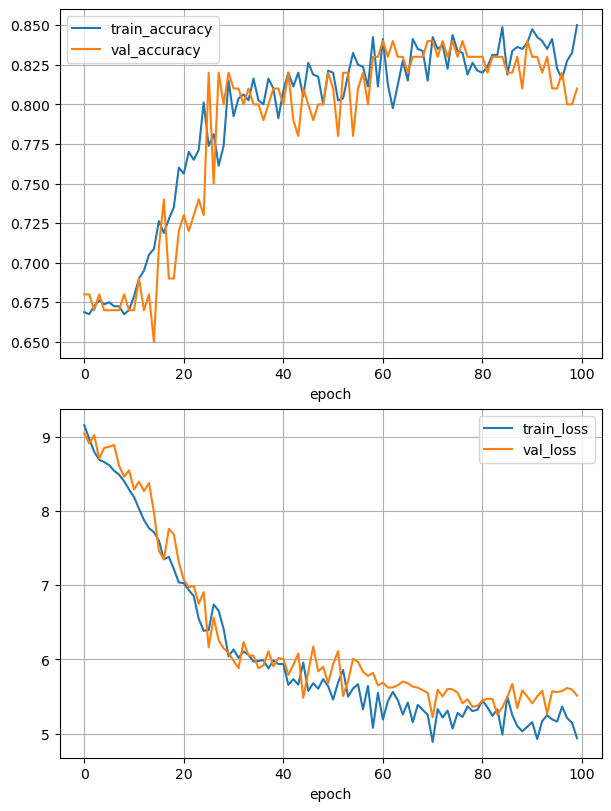

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

In [15]:
import torch
import numpy as np

from sklearn.metrics import roc_curve, auc
from typing import Iterable, Tuple


def get_roc(
    model: torch.nn.Module, loader: Iterable, seed: int = 1, exp: bool = True
) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, np.ndarray]:
    """Run a model on the a dataset and calculate ROC and AUC.

    The model output values are by default exponentiated before calculating the ROC.
    XXX Why?

    :param model: model to test
    :param loader: data loader
    :param seed: PyTorch random seed
    :param exp: if `True`, exponential model outputs before calculating ROC
    :return: a tuple `(fpr, tpr, auc_value, ys, outs)`, where `(fpr, tpr)` are vectors
        representing the ROC curve; `auc_value` is the AUC; `ys` and `outs` are the
        expected (ground-truth) outputs and the (exponentiated) model outputs,
        respectively
    """
    # keep everything reproducible!
    torch.manual_seed(seed)

    # make sure the model is in evaluation mode
    model.eval()

    outs = []
    ys = []
    device = next(iter(model.parameters())).device
    for tb in loader:
        tb = tb.to(device)
        if exp:
            outs.append(torch.exp(model(tb)).detach().cpu().clone().numpy())
        else: ### Take the final element in the list here (can tidy this up once the model is working)
            outs.append(model(tb)[-1].detach().cpu().clone().numpy())

        ys.append(tb.y.detach().cpu().clone().numpy())

    outs = np.concatenate(outs)
    ys = np.concatenate(ys)
    if len(outs.shape) == 1:
        outs = np.vstack([1 - outs, outs]).T
    if outs.shape[-1] == 1: ## Pnet model outputs a single squeezed tensor
        outs=np.array([1-outs.flatten(),outs.flatten()]).T
    fpr, tpr, _ = roc_curve(ys, outs[:, 1])
    auc_value = auc(fpr, tpr)

    return fpr, tpr, auc_value, ys, outs

In [16]:
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader,exp=False)
test_acc=accuracy_score(ys, outs[:, 1] > 0.5)
test_aupr=average_precision_score(ys, outs[:, 1])
test_f1=f1_score(ys, outs[:, 1] > 0.5)
test_precision=precision_score(ys, outs[:, 1] > 0.5)
test_recall=recall_score(ys, outs[:, 1] > 0.5)

print("accuracy", test_acc)
print("auc", test_auc)
print("aupr", test_aupr)
print("f1", test_f1)
print("precision", test_precision)
print("recall", test_recall)

accuracy 0.82
auc 0.9255793226381461
aupr 0.8626869811722115
f1 0.6785714285714287
precision 0.8636363636363636
recall 0.5588235294117647
